# Step 1: Downloading Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
import tarfile
from urllib.request import urlretrieve
import xml.etree.ElementTree as etree
import os
from imageio import imread
from skimage.transform import resize
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Input, Convolution2D, Dropout, GlobalAveragePooling2D, Flatten, Dense
from keras.models import Model
import h5py

# Download Pascal VOC 2007 dataset
URL_VOC = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"
FILE_VOC = "Files/VOCtrainval_06-Nov-2007.tar"
FOLDER_VOC = "Files/VOCdevkit"

if not op.exists(FILE_VOC):
    print(f'Downloading from {URL_VOC} to {FILE_VOC}...')
    urlretrieve(URL_VOC, FILE_VOC)

if not op.exists(FOLDER_VOC):
    print(f'Extracting {FILE_VOC}...')
    tar = tarfile.open(FILE_VOC)
    tar.extractall(path="Files")
    tar.close()

# Download precomputed representations
URL_REPRESENTATIONS = ("https://github.com/m2dsupsdlclass/lectures-labs/releases/download/0.2/voc_representations.h5")
FILE_REPRESENTATIONS = "Files/voc_representations.h5"

if not op.exists(FILE_REPRESENTATIONS):
    print(f'Downloading from {URL_REPRESENTATIONS} to {FILE_REPRESENTATIONS}...')
    urlretrieve(URL_REPRESENTATIONS, FILE_REPRESENTATIONS)

Using TensorFlow backend.


# Step 2: Loading and Preprocessing Annotations

In [2]:
# Define classes and mappings
filters = ["dog", "cat", "bus", "car", "aeroplane"]
idx2labels = {k: v for k, v in enumerate(filters)}
labels2idx = {v: k for k, v in idx2labels.items()}
print("Index to label mapping:", idx2labels)
print("Label to index mapping:", labels2idx)

# Function to parse XML annotations
def extract_xml_annotation(filename):
    z = etree.parse(filename)
    objects = z.findall("./object")
    size = (int(z.find(".//width").text), int(z.find(".//height").text))
    fname = z.find("./filename").text
    dicts = [{obj.find("name").text: [int(obj.find("bndbox/xmin").text),
                                     int(obj.find("bndbox/ymin").text),
                                     int(obj.find("bndbox/xmax").text),
                                     int(obj.find("bndbox/ymax").text)]}
             for obj in objects]
    return {"size": size, "filename": fname, "objects": dicts}

# Load and filter annotations
annotations = []
annotation_folder = "Files/VOCdevkit/VOC2007/Annotations/"
for filename in sorted(os.listdir(annotation_folder)):
    annotation = extract_xml_annotation(op.join(annotation_folder, filename))
    new_objects = [obj for obj in annotation["objects"] if list(obj.keys())[0] in filters]
    if len(new_objects) == 1:  # Keep images with exactly one object
        annotation["class"] = list(new_objects[0].keys())[0]
        annotation["bbox"] = list(new_objects[0].values())[0]
        annotation.pop("objects")
        annotations.append(annotation)

print("Number of images with annotations:", len(annotations))
print("Sample annotation:", annotations[0])

Index to label mapping: {0: 'dog', 1: 'cat', 2: 'bus', 3: 'car', 4: 'aeroplane'}
Label to index mapping: {'dog': 0, 'cat': 1, 'bus': 2, 'car': 3, 'aeroplane': 4}
Number of images with annotations: 1264
Sample annotation: {'size': (500, 333), 'filename': '000007.jpg', 'class': 'car', 'bbox': [141, 50, 500, 330]}


# Step 3: Precomputing Image Representations with ResNet50

In [3]:
# Load headless ResNet50
base_model = ResNet50(include_top=False, weights='imagenet')
headless_conv = Model(inputs=base_model.input, outputs=base_model.output)
print("Headless ResNet50 output shape:", headless_conv.output_shape)

# Function to predict on a batch of images
def predict_batch(model, img_batch_path, img_size=(224, 224)):
    img_list = []
    for im_path in img_batch_path:
        img = imread(im_path)
        img = resize(img, img_size, preserve_range=True)
        img = img.astype('float32')
        img_list.append(img)
    img_batch = np.stack(img_list, axis=0)
    return model.predict(preprocess_input(img_batch))

# Test on a small batch
test_paths = [op.join("Files/VOCdevkit/VOC2007/JPEGImages", annotations[i]["filename"]) for i in range(2)]
test_reprs = predict_batch(headless_conv, test_paths)
print("Test representations shape:", test_reprs.shape)

# Load precomputed representations
with h5py.File('Files/voc_representations.h5', 'r') as h5f:
    reprs = h5f['reprs'][:]
print("Loaded representations shape:", reprs.shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



c:\users\kerem\github\python-keras-deep-learning\advml\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Headless ResNet50 output shape: (None, None, None, 2048)

Test representations shape: (2, 7, 7, 2048)
Loaded representations shape: (1264, 7, 7, 2048)


# Step 4: Preparing Ground Truth Tensors

In [4]:
img_resize = 224
num_classes = len(labels2idx)

def tensorize_ground_truth(annotations):
    all_boxes = []
    all_cls = []
    for annotation in annotations:
        cls = np.zeros(num_classes)
        cls_idx = labels2idx[annotation["class"]]
        cls[cls_idx] = 1.0
        coords = annotation["bbox"]
        size = annotation["size"]
        x1, y1, x2, y2 = (coords[0] * img_resize / size[0],
                          coords[1] * img_resize / size[1],
                          coords[2] * img_resize / size[0],
                          coords[3] * img_resize / size[1])
        cx, cy = (x2 + x1) / 2, (y2 + y1) / 2
        w, h = x2 - x1, y2 - y1
        boxes = np.array([cx, cy, w, h])
        all_boxes.append(boxes)
        all_cls.append(cls)
    return np.vstack(all_cls), np.vstack(all_boxes)

classes, boxes = tensorize_ground_truth(annotations)
print("Classes shape:", classes.shape)
print("Boxes shape:", boxes.shape)
print("Sample classes:", classes[:2])
print("Sample boxes:", boxes[:2])

Classes shape: (1264, 5)
Boxes shape: (1264, 4)
Sample classes: [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
Sample boxes: [[143.584      127.80780781 160.832      188.34834835]
 [113.568      123.43543544  87.36       116.37237237]]


# Step 5: Interpreting Model Outputs

In [5]:
def interpret_output(cls, boxes, img_size=(500, 333)):
    cls_idx = np.argmax(cls)
    confidence = cls[cls_idx]
    classname = idx2labels[cls_idx]
    cx, cy, w, h = boxes
    small_box = [max(0, cx - w / 2), max(0, cy - h / 2),
                 min(img_resize, cx + w / 2), min(img_resize, cy + h / 2)]
    fullsize_box = [int(small_box[0] * img_size[0] / img_resize),
                    int(small_box[1] * img_size[1] / img_resize),
                    int(small_box[2] * img_size[0] / img_resize),
                    int(small_box[3] * img_size[1] / img_resize)]
    return {"class": classname, "confidence": confidence, "bbox": fullsize_box}

# Test interpretation
img_idx = 1
interpreted = interpret_output(classes[img_idx], boxes[img_idx], img_size=annotations[img_idx]["size"])
print("Original annotation:", annotations[img_idx])
print("Interpreted output:", interpreted)

Original annotation: {'size': (500, 333), 'filename': '000012.jpg', 'class': 'car', 'bbox': [156, 97, 351, 270]}
Interpreted output: {'class': 'car', 'confidence': 1.0, 'bbox': [156, 97, 351, 270]}


# Step 6: Computing Intersection over Union (IoU)

In [6]:
def iou(boxA, boxB):
    x0 = max(boxA[0], boxB[0])
    y0 = max(boxA[1], boxB[1])
    x1 = min(boxA[2], boxB[2])
    y1 = min(boxA[3], boxB[3])
    inter_area = max(x1 - x0, 0) * max(y1 - y0, 0) + 1
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    return inter_area / float(boxA_area + boxB_area - inter_area)

# Test IoU
img_idx = 1
original = annotations[img_idx]
interpreted = interpret_output(classes[img_idx], boxes[img_idx], img_size=original["size"])
print("IoU between original and interpreted:", iou(original["bbox"], interpreted["bbox"]))

IoU between original and interpreted: 0.9786493385936412


# Step 7: Building the Classification and Localization Model

In [7]:
def classif_and_loc(num_classes):
    model_input = Input(shape=(7, 7, 2048))
    x = GlobalAveragePooling2D()(model_input)
    x = Dropout(0.2)(x)
    head_classes = Dense(num_classes, activation="softmax", name="head_classes")(x)
    y = Convolution2D(4, (1, 1), strides=1, activation='relu', name='hidden_conv')(model_input)
    y = Flatten()(y)
    y = Dropout(0.2)(y)
    head_boxes = Dense(4, name="head_boxes")(y)
    model = Model(model_input, outputs=[head_classes, head_boxes], name="resnet_loc")
    model.compile(optimizer="adam", loss=['categorical_crossentropy', "mse"],
                  loss_weights=[1., 1/(224*224)])
    return model

model = classif_and_loc(num_classes)
model.summary()

# Test prediction
inputs = reprs[:10]
out = model.predict(inputs)
print("Model output shapes:", out[0].shape, out[1].shape)

Model: "resnet_loc"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 7, 7, 2048)   0                                            
__________________________________________________________________________________________________
hidden_conv (Conv2D)            (None, 7, 7, 4)      8196        input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 196)          0           hidden_conv[0][0]                
_________________________________________________________________________________________

# Step 8: Visualizing Predictions

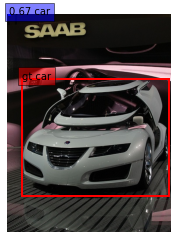

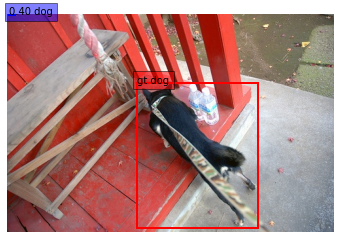

In [8]:
def patch(axis, bbox, display_txt, color):
    coords = (bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1
    axis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    axis.text(bbox[0], bbox[1], display_txt, bbox={'facecolor': color, 'alpha': 0.5})

def plot_annotations(img_path, annotation=None, ground_truth=None):
    img = imread(img_path)
    plt.imshow(img)
    current_axis = plt.gca()
    if ground_truth:
        text = "gt " + ground_truth["class"]
        patch(current_axis, ground_truth["bbox"], text, "red")
    if annotation:
        conf = f"{annotation['confidence']:.2f} "
        text = conf + annotation["class"]
        patch(current_axis, annotation["bbox"], text, "blue")
    plt.axis('off')
    plt.show()

def display(index, ground_truth=True):
    res = model.predict(reprs[index][np.newaxis])
    output = interpret_output(res[0][0], res[1][0], img_size=annotations[index]["size"])
    plot_annotations(op.join("Files/VOCdevkit/VOC2007/JPEGImages", annotations[index]["filename"]),
                     output, annotations[index] if ground_truth else None)

# Test visualization
display(2)
display(194)

# Step 9: Evaluating Model Performance

In [9]:
def accuracy_and_iou(preds, trues, threshold=0.5):
    sum_valid, sum_accurate, sum_iou = 0, 0, 0
    num = len(preds)
    for pred, true in zip(preds, trues):
        iou_value = iou(pred["bbox"], true["bbox"])
        if pred["class"] == true["class"] and iou_value > threshold:
            sum_valid += 1
        sum_iou += iou_value
        if pred["class"] == true["class"]:
            sum_accurate += 1
    return sum_accurate / num, sum_iou / num, sum_valid / num

def compute_acc(train=True):
    if train:
        beg, end = 0, (9 * len(annotations) // 10)
        split_name = "train"
    else:
        beg, end = (9 * len(annotations)) // 10, len(annotations)
        split_name = "test"
    res = model.predict(reprs[beg:end])
    outputs = [interpret_output(cls, box, img_size=annotations[i]["size"])
               for i, (cls, box) in enumerate(zip(res[0], res[1]))]
    acc, iou, valid = accuracy_and_iou(outputs, annotations[beg:end], threshold=0.5)
    print(f'{split_name} acc: {acc:.3f}, mean iou: {iou:.3f}, acc_valid: {valid:.3f}')

# Evaluate untrained model
compute_acc(train=True)
compute_acc(train=False)

train acc: 0.322, mean iou: 0.000, acc_valid: 0.000
test acc: 0.331, mean iou: 0.000, acc_valid: 0.000


# Step 10: Training the Model

Training samples: 1138
Train on 1138 samples, validate on 126 samples
Epoch 1/10
 - 1s - loss: 1.0643 - head_classes_loss: 0.8218 - head_boxes_loss: 11771.5918 - val_loss: 0.3661 - val_head_classes_loss: 0.2882 - val_head_boxes_loss: 3790.2375
Epoch 2/10
 - 0s - loss: 0.3369 - head_classes_loss: 0.2710 - head_boxes_loss: 3297.0884 - val_loss: 0.2900 - val_head_classes_loss: 0.2320 - val_head_boxes_loss: 2789.8289
Epoch 3/10
 - 0s - loss: 0.2537 - head_classes_loss: 0.2055 - head_boxes_loss: 2602.2800 - val_loss: 0.2646 - val_head_classes_loss: 0.2154 - val_head_boxes_loss: 2348.2424
Epoch 4/10
 - 0s - loss: 0.2052 - head_classes_loss: 0.1606 - head_boxes_loss: 2163.9185 - val_loss: 0.2330 - val_head_classes_loss: 0.1893 - val_head_boxes_loss: 2094.9023
Epoch 5/10
 - 0s - loss: 0.1641 - head_classes_loss: 0.1253 - head_boxes_loss: 1891.6060 - val_loss: 0.2278 - val_head_classes_loss: 0.1869 - val_head_boxes_loss: 1953.8232
Epoch 6/10
 - 0s - loss: 0.1348 - head_classes_loss: 0.1007 - he

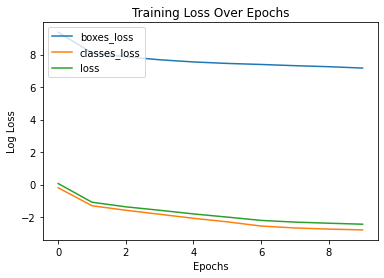

train acc: 0.998, mean iou: 0.484, acc_valid: 0.592
test acc: 0.929, mean iou: 0.383, acc_valid: 0.386


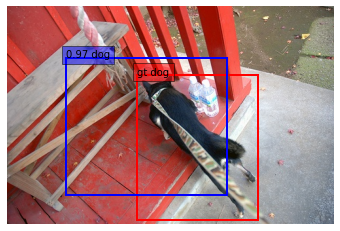

In [10]:
# Split dataset
test_num = reprs.shape[0] // 10
train_num = reprs.shape[0] - test_num
train_inputs = reprs[:train_num]
test_inputs = reprs[train_num:]
train_cls, train_boxes = classes[:train_num], boxes[:train_num]
test_cls, test_boxes = classes[train_num:], boxes[train_num:]
print("Training samples:", train_num)

# Rebuild and train the model
model = classif_and_loc(num_classes)
batch_size = 32
history = model.fit(train_inputs, y=[train_cls, train_boxes],
                    validation_data=(test_inputs, [test_cls, test_boxes]),
                    batch_size=batch_size, epochs=10, verbose=2)

# Plot training history
plt.plot(np.log(history.history["head_boxes_loss"]), label="boxes_loss")
plt.plot(np.log(history.history["head_classes_loss"]), label="classes_loss")
plt.plot(np.log(history.history["loss"]), label="loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Training Loss Over Epochs")
plt.show()

# Evaluate trained model
compute_acc(train=True)
compute_acc(train=False)

# Visualize a test example
display(194)